# Explore ECG dataset
Stefan/Yuzhao Heng
Since Sun. Oct. 31st, 2021


Check out data format of publicly available datasets & determine which to use.

e.g. If they contain 12-lead recordings, is each beat labeled


## Setup



In [3]:
import os
import glob

import h5py
import pandas as pd
import wfdb
from wfdb import processing
from scipy.io import loadmat
from icecream import ic


from util import *


!ls ../../datasets
dsets = list(config('datasets').keys())
ic(dsets)

BASE = os.path.join(PATH_BASE, DIR_DSET)



CODE-test            Georgia-12-Lead      PTB-Diagnostic
CSPC-2018            KIT-20-PVC           PTB-XL
CSPC-2018-CinC       MIT-BIH-MVED         St-Petersburg-INCART
CSPC-2018-Extra-CinC Ningbo-CinC          Stef-Combined
Chapman-Shaoxing     PSTOV


ic| dsets: ['BIH_MVED',
            'INCART',
            'PTB_XL',
            'PTB_Diagnostic',
            'CSPC',
            'CSPC_CinC',
            'CSPC_Extra_CinC',
            'G12EC',
            'CHAP_SHAO',
            'CODE_TEST',
            'my']


## INCART
St Petersburg INCART 12-lead Arrhythmia Database


### Is the R-peak accurate, i.e. local maxima/minima?



ic| rec.p_signal.shape: (462600, 12)
ic| rec.fs: 257


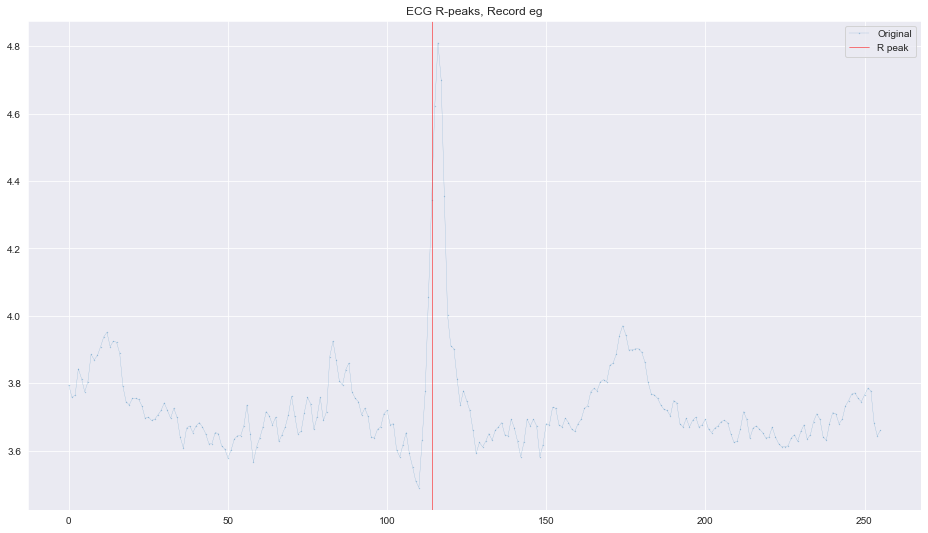

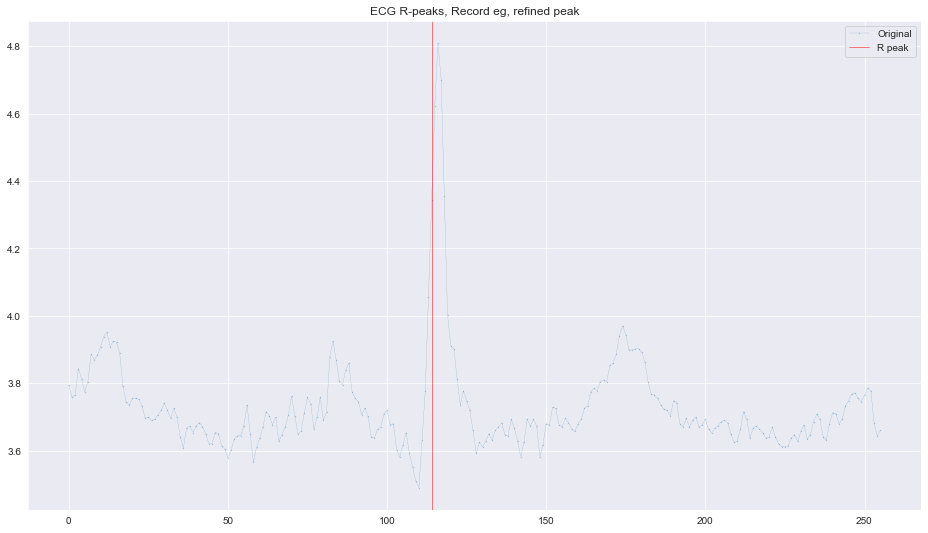

In [4]:
# dset = config(f'datasets.{dsets[1]}')
# ic(dset['nm'])
# rnm = 'I01'
# fnm = f'{dset["dir_nm"]}/{rnm}'
dnm = 'INCART'
fnm = get_rec_paths(dnm)[0]
fnm = fnm[:fnm.index('.')]
# ic(fnm)
rec = wfdb.rdrecord(fnm)
# rec = get_record_eg(dnm)
ic(rec.p_signal.shape)
ic(rec.fs)

sampto = 2 ** 8
rec = wfdb.rdrecord(fnm, sampto=sampto)
# rec = get_record_eg(dnm, n=sampto)
ann = wfdb.rdann(fnm, extension='atr', sampto=sampto)

sig = rec.p_signal[:, 0]
idxs_rpeak = ann.sample
plot_rpeak(sig, idxs_rpeak, title='Record eg')
idxs_rpeak = refine_rpeak(sig, idxs_rpeak, fqs=rec.fs)
plot_rpeak(sig, idxs_rpeak, title='Record eg, refined peak')



## KIT-20-PVC
Human PVC and Paced beats (KIT-20-PVC_Clinical_1906-10-30)

BSPM data, not ECG


In [5]:
# fnm = 'KIT-20-PVC/Interventions/InterventionPace1/Subject20_run01.mat'
# mat = loadmat(fnm)
# ic(mat)

fnm = f'{BASE}/KIT-20-PVC/Interventions/PVC/Subject20_run01.mat'
mat = loadmat(fnm)
data = mat['bspm']
ic(type(data), data.shape)

data = data[0][0]
ic(type(data), len(data))

data, unit, beat_type, file_nm = data
ic(data, unit, beat_type, file_nm)
ic(type(data), data.shape)



ic| type(data): <class 'numpy.ndarray'>, data.shape: (1, 1)
ic| type(data): <class 'numpy.void'>, len(data): 4
ic| data: array([[ 0.        , -0.00313843, -0.0030269 , ..., -0.03043172,
                  -0.03204859, -0.02841264],
                 [ 0.        , -0.00255374, -0.00326898, ...,  0.03951429,
                   0.03700217,  0.03904396],
                 [ 0.        ,  0.00011707,  0.00174486, ...,  0.03171732,
                   0.03228344,  0.03745946],
                 ...,
                 [ 0.        ,  0.0028107 ,  0.0032005 , ...,  0.01739727,
                   0.02797695,  0.03283168],
                 [ 0.        ,  0.00250143,  0.00237055, ...,  0.04354762,
                   0.04959223,  0.05541237],
                 [ 0.        ,  0.0039265 ,  0.00644877, ...,  0.05749454,
                   0.06818049,  0.07494887]])
    unit: array(['mV'], dtype='<U2')
    beat_type: array(['PVC'], dtype='<U3')
    file_nm: array(['Subject20_run01.mat'], dtype='<U19')
ic| type

(numpy.ndarray, (63, 180))

## PSTOV
[Multiple Ventricle Pacing Sites Pat#3 (Charles_PSTOV-12-07-29)](https://edgar.sci.utah.edu/human-pacing-site/11-charles_pstov-12-07-29.html)

Seems to only contain the QRS complex


ic| mat: {'__globals__': [],
          '__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Fri Oct 1'
                        b'6 14:36:16 2015',
          '__version__': '1.0',
          'bspm': array([[(array([[ 0.      ,  0.022696,  0.032321, ...,  0.042838,  0.018738,
                  0.010643],
                [ 0.      ,  0.020598,  0.030319, ...,  0.009359, -0.012449,
                 -0.022405],
                [ 0.      ,  0.017847,  0.025191, ..., -0.009756, -0.033478,
                 -0.042839],
                ...,
                [ 0.      ,  0.003845,  0.008847, ...,  0.009791, -0.005612,
                 -0.009291],
                [ 0.      ,  0.006458,  0.012307, ...,  0.003302, -0.014493,
                 -0.018685],
                [ 0.      ,  0.007566,  0.012633, ..., -0.032618, -0.047524,
                 -0.053156]]), array(['mV'], dtype='<U2'), array(['BSPM from pacing localization on subject3 from the pstov dataset. Ventricle LV, location ID: 1

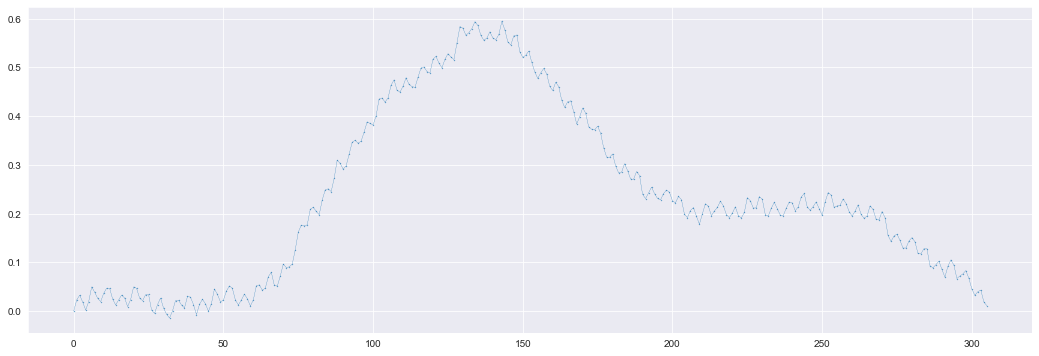

In [6]:
fnm = f'{BASE}/PSTOV/Interventions/interventionLeftVentPace01/2012-07-29Subject_run1'
mat = loadmat(fnm)
ic(mat)
data = mat['bspm']
ic(type(data), data.shape)

data = data[0][0]
ic(type(data), len(data))

data, unit, description = data
ic(data, unit, description)
ic(type(data), data.shape)

plot_single(data[0])



## PTB-XL
Looks like I need to detect R peaks myself



ic| dnm: 'PTB_XL'
ic| dset_['nm']: 'PTB-XL, a large publicly available electrocardiography dataset'
ic| rec_.p_signal.shape: (2048, 12)
ic| rec_.comments: []


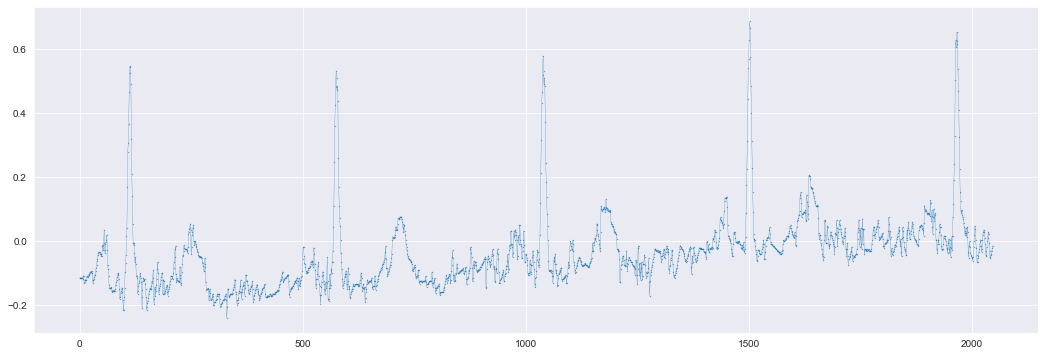

ic| hard_peaks.shape: (63,)
    hard_peaks[:20]: array([ 7,  9, 10, 17, 18, 27, 30, 49, 52, 53, 55, 57, 61, 71, 73, 74, 86,
                            90, 95, 99])
ic| soft_peaks.shape: (6,)
    soft_peaks[:20]: array([ 44,  68,  77, 184, 220, 236])


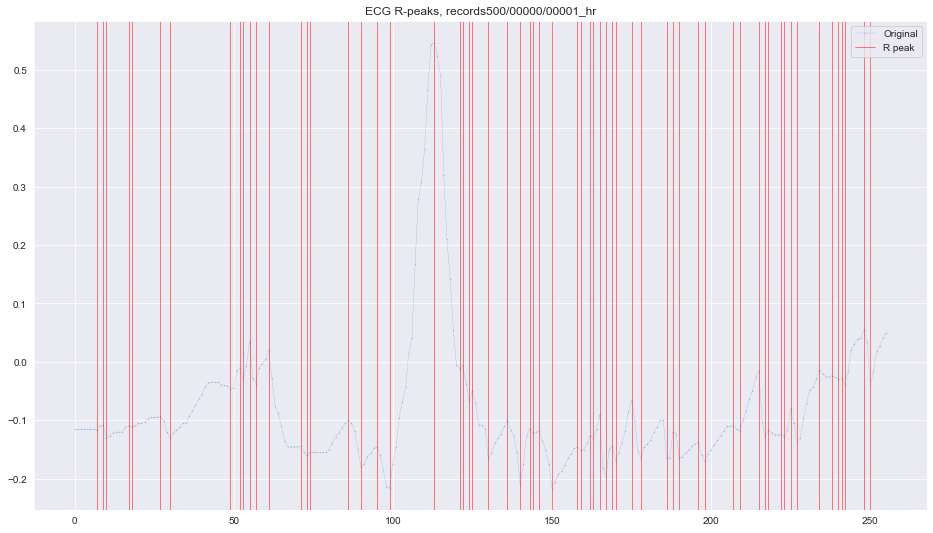

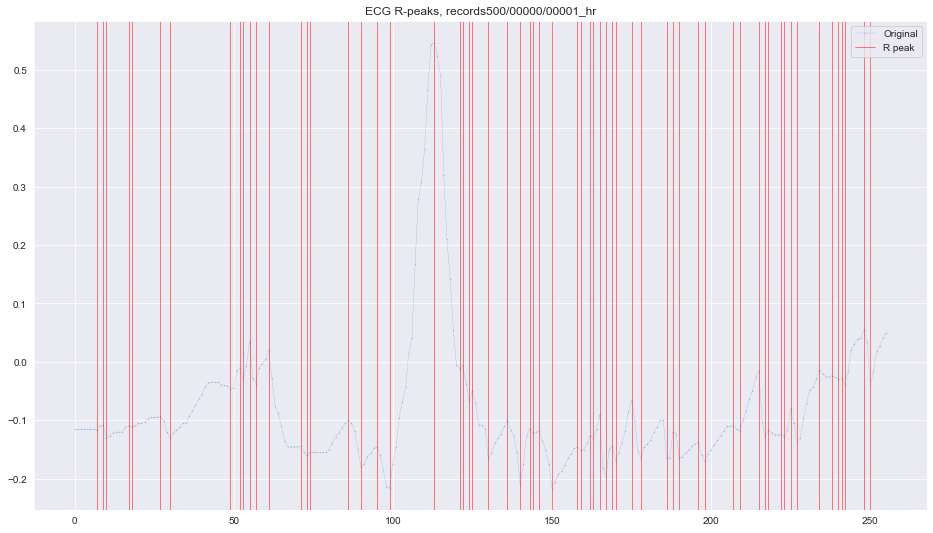

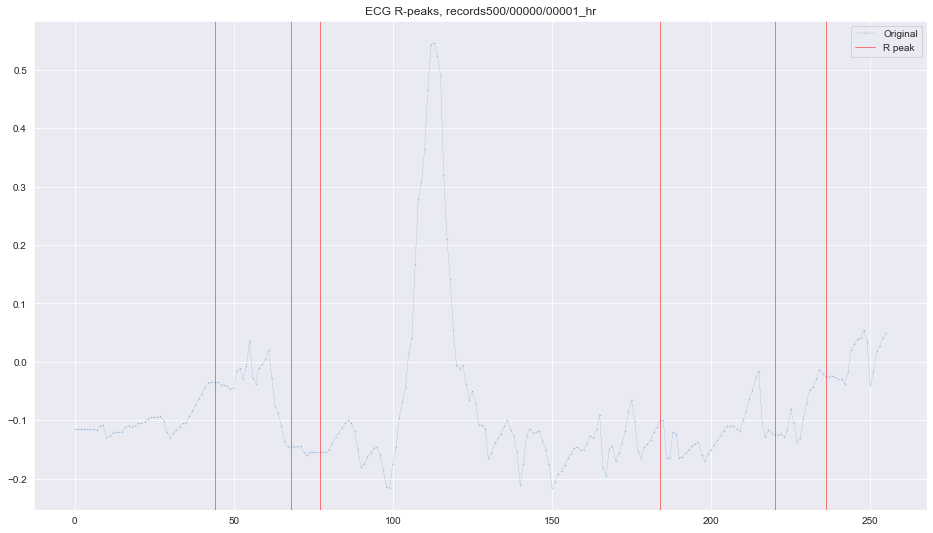

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr


In [7]:
def explore_singe_lead(dnm_, rnm_, sampto_=2**8):
    dset_ = config(f'{DIR_DSET}.{dnm_}')
    ic(dset_['nm'])

    fnm_ = f'{BASE}/{dset_["dir_nm"]}/{rnm_}'

    rec_ = wfdb.rdrecord(fnm_, sampto=sampto_ * 2**3)
    ic(rec_.p_signal.shape)
    ic(rec_.comments)

    sig_ = rec_.p_signal[:, 0]
    plot_single(sig_)

    rec_ = wfdb.rdrecord(fnm_, sampto=sampto_)
    sig_ = rec_.p_signal[:, 0]

    hard_peaks, soft_peaks = wfdb.processing.find_peaks(sig_)
    ic(hard_peaks.shape, hard_peaks[:20])
    ic(soft_peaks.shape, soft_peaks[:20])
    plot_rpeak(sig_, hard_peaks, title=rnm_)
    plot_rpeak(sig_, hard_peaks, title=rnm_)
    plot_rpeak(sig_, soft_peaks, title=rnm_)

dnm = dsets[2]
ic(dnm)
# R-peak from wfdb doesn't look good
explore_singe_lead(dnm, rnm_='records500/00000/00001_hr')

dir_nm = config(f'{DIR_DSET}.{dnm}.dir_nm')
path = f'{DIR_DSET}/{dir_nm}'
df = pd.read_csv(f'{PATH_BASE}/{path}/ptbxl_database.csv')
df.head(2)


## PTB-Diagnostic



ic| dset_['nm']: 'PTB Diagnostic ECG Database'
ic| rec_.p_signal.shape: (8192, 15)
ic| rec_.comments: ['age: 81',
                    'sex: female',
                    'ECG date: 01/10/1990',
                    'Diagnose:',
                    'Reason for admission: Myocardial infarction',
                    'Acute infarction (localization): infero-latera',
                    'Former infarction (localization): no',
                    'Additional diagnoses: Diabetes mellitus',
                    'Smoker: no',
                    'Number of coronary vessels involved: 1',
                    'Infarction date (acute): 29-Sep-90',
                    'Previous infarction (1) date: n/a',
                    'Previous infarction (2) date: n/a',
                    'Hemodynamics:',
                    'Catheterization date: 16-Oct-90',
                    'Ventriculography: Akinesia inferior wall',
                    'Chest X-ray: Heart size upper limit of norm',
                    'Pe

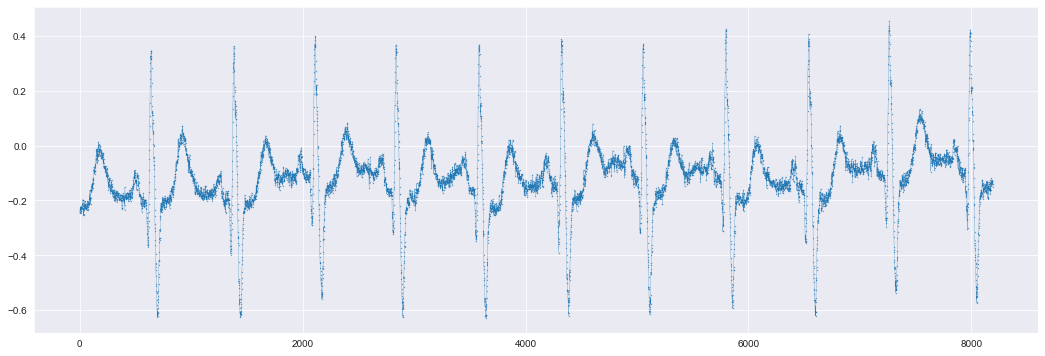

ic| hard_peaks.shape: (429,)
    hard_peaks[:20]: array([ 6, 10, 14, 16, 20, 23, 25, 33, 35, 37, 44, 47, 49, 54, 56, 58, 59,
                            62, 64, 65])
ic| soft_peaks.shape: (12,)
    soft_peaks[:20]: array([  7,  29,  42,  51, 195, 212, 227, 441, 465, 519, 591, 597])


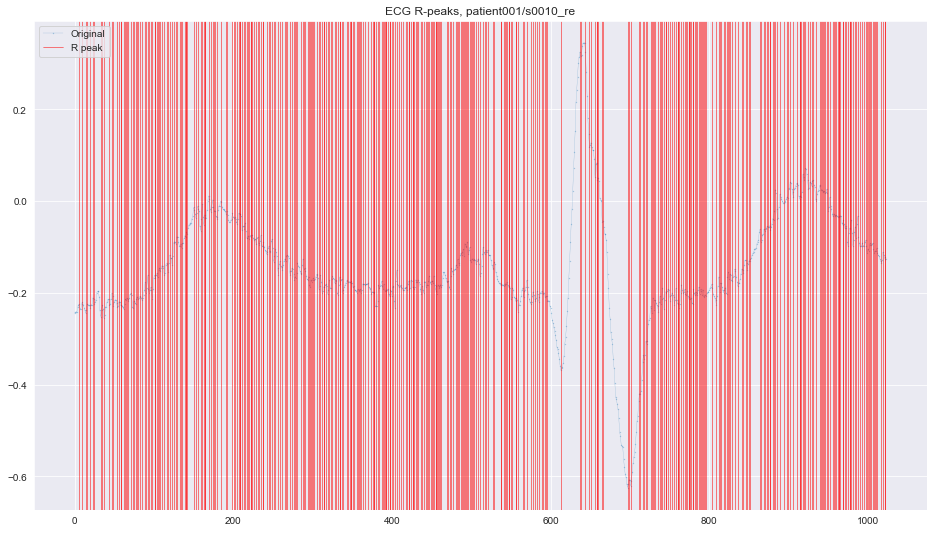

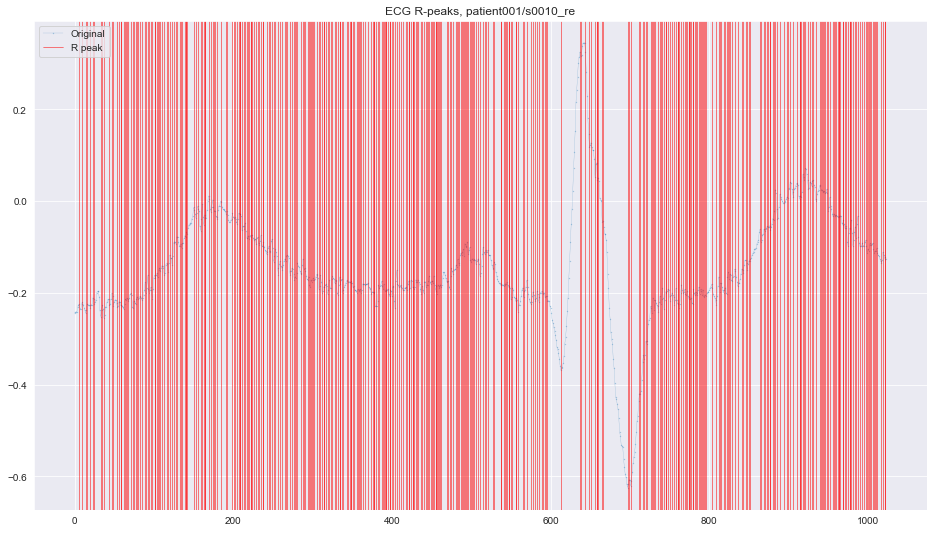

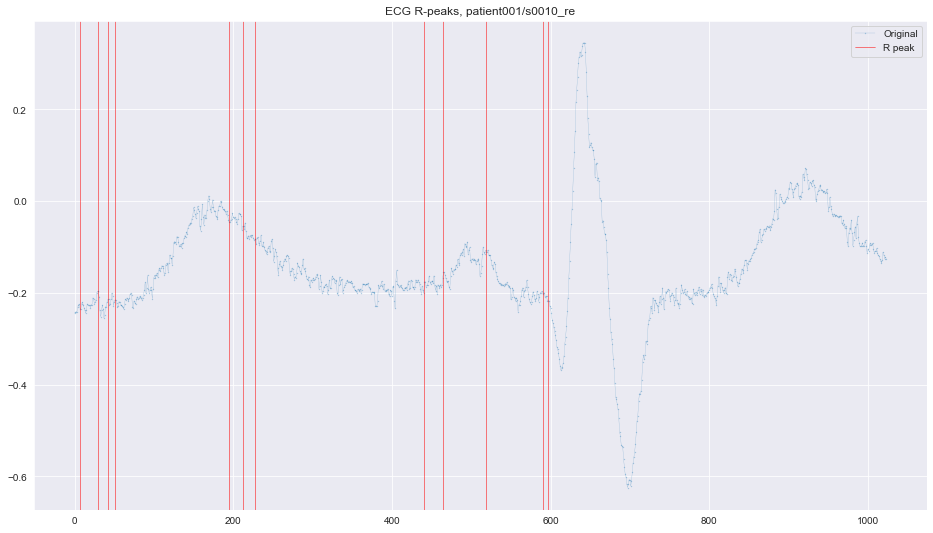

In [8]:
dnm = dsets[3]
explore_singe_lead(dnm, rnm_='patient001/s0010_re', sampto_=2**10)


## CSPC-2018

China Physiological Signal Challenge 2018



In [9]:
fnm = f'{BASE}/CSPC-2018/A0001.mat'
mat = loadmat(fnm)
ic(mat.keys())

data = mat['ECG']
ic(type(data), data.shape, data.dtype)
data = data[0][0]
ic(type(data), data.shape)
sex, age, sig = data
ic(sex, age, sig)
ic(sig.shape)
ic(sig[0, :20])



ic| mat.keys(): dict_keys(['__header__', '__version__', '__globals__', 'ECG'])
ic| type(data): <class 'numpy.ndarray'>
    data.shape: (1, 1)
    data.dtype: dtype([('sex', 'O'), ('age', 'O'), ('data', 'O')])
ic| type(data): <class 'numpy.void'>, data.shape: ()
ic| sex: array(['Male'], dtype='<U4')
    age: array([[74]], dtype=uint8)
    sig: array([[ 0.0282288 ,  0.0392288 ,  0.0452288 , ...,  0.2582288 ,
                  0.2592288 ,  0.2592288 ],
                [ 0.00672947,  0.01072947,  0.01472947, ...,  0.24772947,
                  0.24872947,  0.24972947],
                [-0.02149933, -0.02849933, -0.03049933, ..., -0.01049933,
                 -0.01049933, -0.00949933],
                ...,
                [-0.11200653, -0.11000653, -0.10800653, ...,  0.19399347,
                  0.19399347,  0.19499347],
                [-0.5959572 , -0.5899572 , -0.5819572 , ...,  0.3070428 ,
                  0.3070428 ,  0.3070428 ],
                [-0.01558507, -0.00658507,  0.0024149

array([0.0282288, 0.0392288, 0.0452288, 0.0492288, 0.0542288, 0.0562288,
       0.0582288, 0.0602288, 0.0602288, 0.0612288, 0.0652288, 0.0692288,
       0.0732288, 0.0822288, 0.0872288, 0.0952288, 0.1042288, 0.1132288,
       0.1212288, 0.1302288])

## CSPC-2018

But that from CinC, uses the standard `wfdb` format



In [10]:
dnm = 'CSPC_CinC'
d_dset = config(f'{DIR_DSET}.{dnm}')
rnm = 'A0001'
ic(d_dset['nm'])

fnm = f'{BASE}/{d_dset["dir_nm"]}/{rnm}'
ic(fnm)

sampto = 2**8
rec = wfdb.rdrecord(fnm, sampto=sampto)
sig = rec.p_signal

ic(sig.shape)
ic(rec.d_signal)
ic(rec.record_name)
ic(rec.fs)
ic(rec.sig_name)
ic(rec.comments)

ic(sig[:20, 0])  # Differ by 0.0002288?

# ic(vars(rec))

ic| d_dset['nm']: 'China Physiological Signal Challenge 2018 - from CinC'
ic| fnm: '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/CSPC-2018-CinC/A0001'
ic| sig.shape: (256, 12)
ic| rec.d_signal: None
ic| rec.record_name: 'A0001'
ic| rec.fs: 500
ic| rec.sig_name: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ic| rec.comments: ['Age: 74',
                   'Sex: Male',
                   'Dx: 59118001',
                   'Rx: Unknown',
                   'Hx: Unknown',
                   'Sx: Unknown']
ic| sig[:20, 0]: array([0.028, 0.039, 0.045, 0.049, 0.054, 0.056, 0.058, 0.06 , 0.06 ,
                        0.061, 0.065, 0.069, 0.073, 0.082, 0.087, 0.095, 0.104, 0.113,
                        0.121, 0.13 ])


array([0.028, 0.039, 0.045, 0.049, 0.054, 0.056, 0.058, 0.06 , 0.06 ,
       0.061, 0.065, 0.069, 0.073, 0.082, 0.087, 0.095, 0.104, 0.113,
       0.121, 0.13 ])

### What's `Dx` in the comments?
Class label for diagnosis - Confirmed by paper



In [11]:
dir_nm = d_dset['dir_nm']
path = f'{PATH_BASE}/{DIR_DSET}/{dir_nm}'
fmt = f'{path}/{d_dset["rec_fmt"]}'
recs = sorted(glob.iglob(fmt, recursive=True))
ic(recs[:5], len(recs))

n = 256
dxs = [wfdb.rdrecord(fnm[:fnm.index('.')], sampto=1).comments[2] for fnm in recs[:n]]

ic(dxs[:5], len(dxs))
df = pd.DataFrame(dxs)
uniqs = pd.unique(df[0])
ic(list(uniqs), uniqs.size)
ic(df[0].value_counts())



ic| recs[:5]: ['/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/CSPC-2018-CinC/A0001.mat',
               '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/CSPC-2018-CinC/A0002.mat',
               '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/CSPC-2018-CinC/A0003.mat',
               '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/CSPC-2018-CinC/A0004.mat',
               '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/CSPC-2018-CinC/A0005.mat']
    len(recs): 6877
ic| dxs[:5]: ['Dx: 59118001',
              'Dx: 426783006',
              'Dx: 164889003',
              'Dx: 164889003',
              'Dx: 164884008']
    len(dxs): 256
ic| list(uniqs): ['Dx: 59118001',
                  'Dx: 426783006',
                  'Dx: 164889003',
                  'Dx: 164884008',
                  'Dx: 429622005',
                  'Dx: 164909002',
                  'Dx: 164931005',
                  'Dx: 270492004',
    

Dx: 59118001               54
Dx: 426783006              40
Dx: 164889003              33
Dx: 429622005              29
Dx: 164884008              27
Dx: 270492004              18
Dx: 284470004              17
Dx: 164931005              15
Dx: 164909002              10
Dx: 164889003,59118001      4
Dx: 59118001,284470004      3
Dx: 59118001,429622005      1
Dx: 270492004,164931005     1
Dx: 164909002,164884008     1
Dx: 270492004,164884008     1
Dx: 164889003,429622005     1
Dx: 284470004,429622005     1
Name: 0, dtype: int64

## CSPC-2018 extra
An unused dataset that's not publicly available from [original website](http://2018.icbeb.org/Challenge.html),
but available from CinC



In [12]:
dnm = 'CSPC_Extra_CinC'
dset_ = config(f'{DIR_DSET}.{dnm}')
rnm = 'Q0001'
ic(dset_['nm'])

fnm = f'{BASE}/{dset_["dir_nm"]}/{rnm}'
ic(fnm)

sampto = 2**8
rec = wfdb.rdrecord(fnm, sampto=sampto)
sig = rec.p_signal

ic(sig.shape)
ic(rec.d_signal)
ic(rec.record_name)
ic(rec.fs)
ic(rec.sig_name)
ic(rec.comments)

# ic(vars(rec))



ic| dset_['nm']: 'China Physiological Signal Challenge 2018, unused/extra - from CinC'
ic| fnm: '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/CSPC-2018-Extra-CinC/Q0001'
ic| sig.shape: (256, 12)
ic| rec.d_signal: None
ic| rec.record_name: 'Q0001'
ic| rec.fs: 500
ic| rec.sig_name: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ic| rec.comments: ['Age: 53',
                   'Sex: Male',
                   'Dx: 164867002,427084000',
                   'Rx: Unknown',
                   'Hx: Unknown',
                   'Sx: Unknown']


['Age: 53',
 'Sex: Male',
 'Dx: 164867002,427084000',
 'Rx: Unknown',
 'Hx: Unknown',
 'Sx: Unknown']

## Georgia 12-Lead
Georgia 12-lead ECG Challenge (G12EC) Database



In [13]:
dnm = 'G12EC'
d_dset = config(f'{DIR_DSET}.{dnm}')
rnm = 'E00001'  # Looks like the header file is incorrect - `.mat` need to be processed
ic(d_dset['nm'])

fnm = f'{BASE}/{d_dset["dir_nm"]}/{rnm}'
sampto = 2**8
rec = wfdb.rdrecord(fnm, sampto=sampto)
sig = rec.p_signal
ic(rec)
ic(sig.shape)
# ic(vars(rec))
ic(rec.comments)


ic| d_dset['nm']: 'Georgia 12-lead ECG Challenge (G12EC) Database'
ic| rec: <wfdb.io.record.Record object at 0x16a107310>
ic| sig.shape: (256, 12)
ic| rec.comments: ['Age: NaN', 'Sex: Female', 'Dx: 426783006', 'Rx: Unknown', 'Hx: Unknown']


['Age: NaN', 'Sex: Female', 'Dx: 426783006', 'Rx: Unknown', 'Hx: Unknown']

## Chapman-Shaoxing



ic| fnm: '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/Chapman-Shaoxing/ECGData/MUSE_20180111_155115_19000.csv'
ic| df.head(5):         I      II    III     aVR     aVL     aVF      V1      V2      V3  \
                0 -214.72 -229.36 -14.64  224.48 -102.48 -122.00  614.88  814.96  912.56   
                1 -200.08 -209.84  -9.76  204.96  -97.60 -112.24  605.12  819.84  927.20   
                2 -190.32 -195.20  -4.88  195.20  -92.72 -102.48  600.24  829.60  956.48   
                3 -165.92 -165.92   0.00  165.92  -82.96  -82.96  590.48  844.24  971.12   
                4 -161.04 -156.16   4.88  161.04  -82.96  -78.08  585.60  844.24  985.76   
                
                       V4      V5      V6  
                0  126.88 -239.12 -507.52  
                1  165.92 -195.20 -463.60  
                2  204.96 -151.28 -429.44  
                3  239.12 -117.12 -400.16  
                4  273.28  -78.08 -370.88  
    len(df): 5000


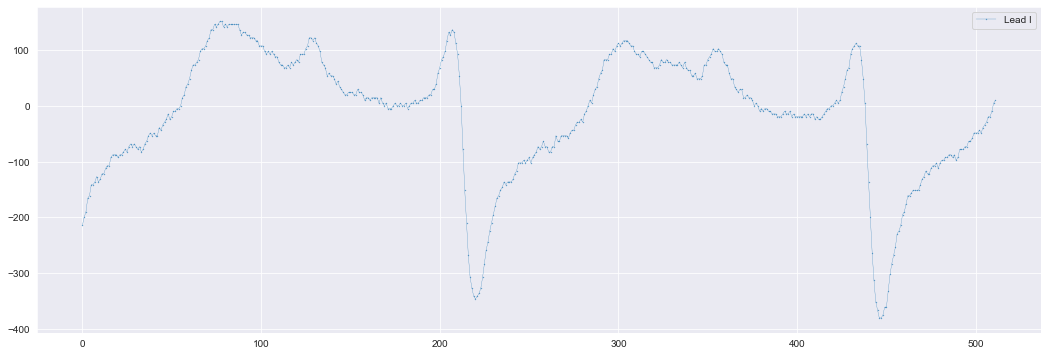

In [14]:
dnm = 'CHAP_SHAO'
fnm = get_rec_paths(dnm)[0]
df = pd.read_csv(fnm)
ic(fnm)
ic(df.head(5), len(df))

plot_single(df.iloc[:512]['I'], label='Lead I')



### CODE-test
Testing data, released from paper *Automatic diagnosis of the 12-lead ECG using a deep neural network*



ic| fnm: '/Users/stefanh/Documents/UMich/Research/ECG-Classify/datasets/CODE-test/ecg_tracings.hdf5'
ic| rec.keys(): <KeysViewHDF5 ['tracings']>
ic| data: <HDF5 dataset "tracings": shape (827, 4096, 12), type "<f8">
    type(data): <class 'h5py._hl.dataset.Dataset'>
ic| data.max(): 66.97279486521437
    data.min(): -51.1795425976763
    data.shape: (827, 4096, 12)


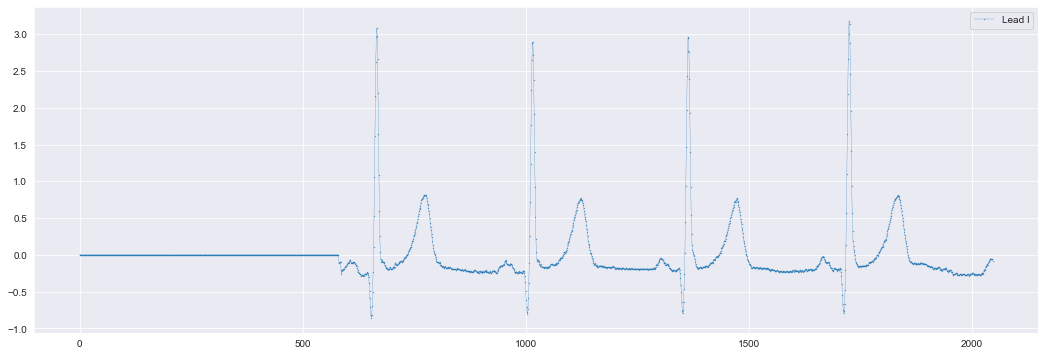

In [15]:
dnm = 'CODE_TEST'
fnm = get_rec_paths(dnm)[0]
ic(fnm)

rec = h5py.File(fnm, 'r')
ic(rec.keys())
data = rec['tracings']
ic(data, type(data))
data = data[:]
ic(data.max(), data.min(), data.shape)

plot_single(data[0, :2048, 0], label='Lead I')

